## OCR文字识别以及文字边框识别
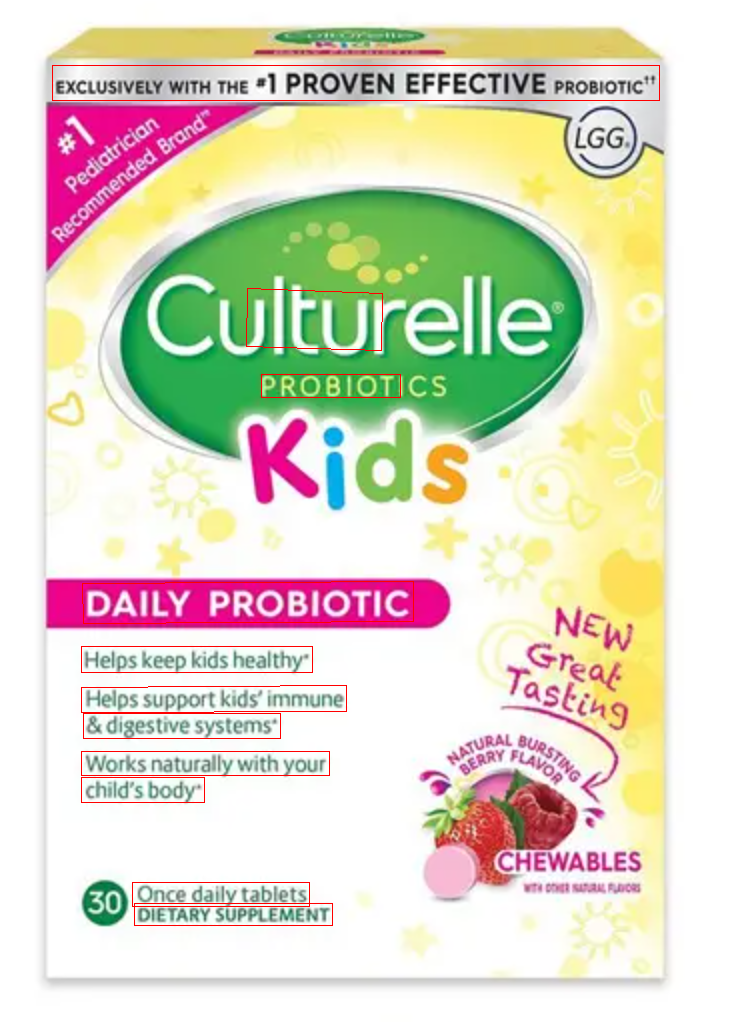

In [ ]:
!pip install surya-ocr opencv-python

In [ ]:
!sudo apt-get update
!sudo apt-get install -y libgl1-mesa-glx

In [ ]:
import json
import os
import copy
from collections import defaultdict
from PIL import Image
from surya.input.langs import replace_lang_with_code, get_unique_langs
from surya.model.recognition.model import load_model as load_recognition_model
from surya.model.recognition.processor import load_processor as load_recognition_processor
from surya.model.recognition.tokenizer import _tokenize
from surya.ocr import run_ocr
from surya.postprocessing.text import draw_text_on_image
from surya.postprocessing.heatmap import draw_polys_on_image
from surya.settings import settings
from surya.model.detection.segformer import load_model as load_det_model, load_processor as load_det_processor



## 测试图片文件路径input_path，文件名在names中

In [ ]:
input_path = 'input'
names = ['1.png','2.png']
images = [ Image.open(os.path.join(input_path,imgfile)) for imgfile in names]

## 需要指定文字编码 
langs = ['en']
replace_lang_with_code(langs)
image_langs = [langs] * len(images)

##保存路径
result_path = './samples'
os.makedirs(result_path, exist_ok=True)


_, lang_tokens = _tokenize("", get_unique_langs(image_langs))
det_processor = load_det_processor()
det_model = load_det_model()
# Prune model moe layer to only include languages we need
rec_model = load_recognition_model(langs=lang_tokens) 
rec_processor = load_recognition_processor()

In [ ]:
#推理
predictions_by_image = run_ocr(images, image_langs, det_model, det_processor, rec_model, rec_processor)


In [ ]:
## 保存图片和json
for idx, (name, image, pred, langs) in enumerate(zip(names, images, predictions_by_image, image_langs)):
    bboxes = [l.bbox for l in pred.text_lines]
    pred_text = [l.text for l in pred.text_lines]
    page_image = draw_text_on_image(bboxes, pred_text, image.size, langs, has_math="_math" in langs)
    page_image.save(os.path.join(result_path, f"{name}_{idx}_text.png"))

    polygons = [p.polygon for p in pred.text_lines]
    bbox_image = draw_polys_on_image(polygons, copy.deepcopy(image))
    bbox_image.save(os.path.join(result_path, f"{name}_{idx}_bbox.png"))

out_preds = defaultdict(list)
for name, pred, image in zip(names, predictions_by_image, images):
    out_pred = pred.model_dump()
    out_pred["page"] = len(out_preds[name]) + 1
    out_preds[name].append(out_pred)

with open(os.path.join(result_path, "results.json"), "w+", encoding="utf-8") as f:
    json.dump(out_preds, f, ensure_ascii=False)

print(f"Wrote results to {result_path}")